In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import requests
import pickle
from scipy import sparse
from collections import Counter

from sklearn.metrics import jaccard_similarity_score

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english') 

from nltk.stem import PorterStemmer
ps = PorterStemmer() 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

# GENERALIZED REGRESSION: 
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix




from sklearn.model_selection import train_test_split



import re

In [2]:
def soctoname(soc):
    return set(var_about(soc)['Unnamed: 6'].values)

def look_dic(string):
    if 'SOCP shave_x_' in string:
        return soctoname(string[-5:])
    elif 'ST_' in string:
        return nst(string[3:])
    elif len(string) <5:
        return set(var_name(string)[var_name(string)['NAME']=='NAME']['Record Type'].values)
    else:
        return string

def is_abi(string):
    if 'SOCP shave_x_' in string:
        return False
    elif 'ST_' in string:
        return False
    elif len(string) <5:
        return False
    else:
        return True

def select_abis(dfeature_coeffs):
    return dfeature_coeffs[dfeature_coeffs['index'].apply(is_abi)][[0]]


In [3]:
###  SETUP PUMS DATA DICTIONARY 
#Source: https://www.census.gov/programs-surveys/acs/data/pums.html )

# Read the data dictionary from the CSV imported by getdata.sh
datadic = pd.read_csv("../census/PUMS_Data_Dictionary_2017.csv").drop_duplicates()

# var_defs : definitions of variables 
var_defs = datadic.groupby('RT').first()
var_defs.head()

#### FUNCTIONS FOR NAVIGATING THE DATA DICTIONARY

# - var_RT(label) : gets information about a label 
# - var_about(word) : gets information about variables including the word in their descriptions (case insensitive)

# All unique variable names
varnames = datadic['RT'].unique()

# All entries for a variable - definition + values 
def var_name(label):
    return BM(datadic).select('RT', 'equals',label).df.drop_duplicates()

# All definitions containing a select string
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))


#select definitions
def names(df):
    return df[df['NAME']=='NAME']


#select values
def vals(df):
    return df[df['NAME']=='VAL']

# Occupation name corresponding to SOCP number
def socp_name(socc):
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values[0]


In [4]:
# BOOLEAN MASKIBG - CLASS OBJECT
# BM - Boolean Masking
class BM:
    def  __init__(self,df):
        self.df= df
    
    def select( self, column , operator , value):
        if operator ==  "equals":
            return BM(self.df[self.df[column]==value])
        elif operator == "contains":
            return BM(self.df[[(value.lower() in str(title).lower()) for title in self.df[column]]])
        elif operator ==  "gt":
            return BM(self.df[self.df[column] > value])
        elif operator ==  "ge":
            return BM(self.df[self.df[column] >= value])
        elif operator ==  "lt":
            return BM(self.df[self.df[column] <= value])
        elif operator ==  "le":
            return BM(self.df[self.df[column] <= value])
        elif operator ==  "ne":
            return BM(self.df[self.df[column] != value])

# var_defs : definitions of variables 
var_defs = datadic.groupby('RT').first()
var_defs.head()
# All unique variable names
varnames = datadic['RT'].unique()

# All entries for a variable - definition + values 
def var_name(label):
    return BM(datadic).select('RT', 'equals',label).df.drop_duplicates()

# All definitions containing a select string
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))


#select definitions
def names(df):
    return df[df['NAME']=='NAME']


#select values
def vals(df):
    return df[df['NAME']=='VAL']

# Occupation name corresponding to SOCP number
def socp_name(socc):
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values[0]


# Read GIPS geocodes for states - run shell command below to import from census.gov
# !curl -O https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls
fips = pd.read_excel('../census/state-geocodes-v2016.xls')
fips.columns = fips.iloc[4]
fips = fips[5:]

# FIPS-BUNBWERS FOR ALL STATES:
all_state_fips=fips[fips['State (FIPS)'] != '00']['State (FIPS)'].values



# nst() translates fips-numbers to state-names
def nst(fipsnr):
    return fips[fips['State (FIPS)'].apply(int) == int(fipsnr)]['Name'].values[0]
# stn() translates state-names to fips-numbers 
def stn(statename):
    return fips[fips['Name'] == statename]['State (FIPS)'].values[0]




# ONET -  OCCUPATION - ABILITY MATRIX

In [5]:
dabmat_weight = pd.read_pickle('dabmat_weight.pkl')
dabmat_std = pd.read_pickle('dabmat_std.pkl')

In [6]:
# A FUNCTION FOR REFORMATTING SOC-CODES IN CENSUS IMPORTS dear deye TO MATCH THE ONET SOC-CODE FORMAT IN abilities / contexts

onet_socp_list = pd.DataFrame(dabmat_weight.index)


# USED FOR CENSUS DATA
def fms(socc):
    code = str(socc).replace('X','0')
    code = re.sub('0$', '', code)
    code = re.sub('0$', '', code)
    return code[:2] + '-' +code[2:]

# USED FOR ONET ABILITIES MATRIX
def soc(socc):
    code = str(socc).replace('-','')
    return code[:5]

In [7]:
#Read the data dictionary from the CSV imported by getdata.sh
onet = {}
onet['Abilities']=pd.read_excel('db_23_2_excel/Abilities.xlsx')
dab = onet['Abilities']=pd.read_excel('db_23_2_excel/Abilities.xlsx')

In [8]:
dab.head()
ddab= dab.groupby('O*NET-SOC Code').first()[['Title']]
def socp_name(code):
    return ddab[ddab['O*NET-SOC Code']==code]

In [9]:
dabmat_weight['SOCP shave']=dabmat_weight['SOCP'].apply(soc)

In [10]:
dabmat_weight

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression,SOCP,SOCP shave
O*NET-SOC Code,,,,,,,,,,,,,,,,,,,,,
11-1011.00,0.00,2.12,3.80,1.40,4.54,1.62,0.00,0.00,0.00,0.00,...,0.00,2.94,0.00,1.75,3.48,0.00,4.43,4.36,11-1011.00,11101
11-1011.03,0.00,1.75,3.50,1.48,4.24,1.94,0.00,0.00,0.00,0.00,...,0.00,2.50,0.53,1.80,2.93,0.37,4.19,4.12,11-1011.03,11101
11-1021.00,1.73,2.06,3.00,1.55,3.75,1.94,0.00,1.10,1.06,0.83,...,1.87,2.88,2.12,2.12,2.62,0.92,4.00,4.00,11-1021.00,11102
11-2011.00,0.83,1.48,3.62,0.37,4.18,1.32,0.00,0.00,0.00,0.00,...,0.00,2.41,1.19,2.81,3.18,1.15,4.00,3.94,11-2011.00,11201
11-2021.00,0.37,1.75,3.43,0.00,4.12,1.15,0.00,0.56,0.00,0.00,...,0.00,2.68,1.24,2.88,3.00,1.10,4.06,4.00,11-2021.00,11202
11-2022.00,0.83,1.94,3.43,1.19,4.12,1.27,0.00,0.00,0.00,0.00,...,0.00,2.50,1.55,1.75,2.44,0.87,4.00,3.94,11-2022.00,11202
11-2031.00,0.00,1.62,3.31,0.00,4.00,1.24,0.00,0.00,0.00,0.00,...,0.00,2.81,1.40,2.12,2.81,0.96,4.06,4.36,11-2031.00,11203
11-3011.00,2.06,2.25,3.12,1.87,3.75,1.80,0.00,1.06,1.06,1.06,...,1.27,3.00,1.48,2.00,2.81,0.69,4.00,3.94,11-3011.00,11301
11-3021.00,2.12,1.87,3.18,2.00,4.00,1.40,0.00,0.87,0.00,0.00,...,0.00,2.36,1.40,2.38,3.00,1.66,4.19,3.93,11-3021.00,11302


In [11]:
dabmat_weight['SOCP shave']=dabmat_weight['SOCP'].apply(soc)
dabmat_std['SOCP shave']=dabmat_weight['SOCP'].apply(soc)
dbmw= dabmat_weight.groupby('SOCP shave').mean()
dbmstd= dabmat_std.groupby('SOCP shave').mean()
dbmw['SOCP shave'] = dbmw.index
dbmstd['SOCP shave'] = dbmw.index

In [12]:
# PREPARE ABILITIES MATRIX FOR ADDING TO CENSUS DATA
dbmwr  = dbmw.groupby('SOCP shave').mean()
dbmwr['SOCP shave'] = dbmwr.index

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'SOCP shave' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


# ONET -  OCCUPATION - CONTEXT MATRIX

In [13]:
def from_onet(table):
    return pd.read_excel(
    zipfile.ZipFile('db_23_2_excel.zip').extract(
        'db_23_2_excel/'+table+'.xlsx')
)

In [14]:
dwcc = from_onet('Work Context Categories')
dwc = from_onet('Work Context')

din = from_onet('Interests')
dkn = from_onet('Knowledge')
dsk = from_onet('Skills')

In [15]:
ls db_23_2_excel

Abilities.xlsx
Alternate Titles.xlsx
Career Changers Matrix.xlsx
Career Starters Matrix.xlsx
Content Model Reference.xlsx
DWA Reference.xlsx
Education, Training, and Experience Categories.xlsx
Education, Training, and Experience.xlsx
Emerging Tasks.xlsx
Green DWA Reference.xlsx
Green Occupations.xlsx
Green Task Statements.xlsx
IWA Reference.xlsx
Interests.xlsx
Job Zone Reference.xlsx
Job Zones.xlsx
Knowledge.xlsx
Level Scale Anchors.xlsx
Occupation Data.xlsx
Occupation Level Metadata.xlsx
Read Me.txt
Sample of Reported Titles.xlsx
Scales Reference.xlsx
Skills.xlsx
Survey Booklet Locations.xlsx
Task Categories.xlsx
Task Ratings.xlsx
Task Statements.xlsx
Tasks to DWAs.xlsx
Tasks to Green DWAs.xlsx
Technology Skills.xlsx
Tools Used.xlsx
Tools and Technology.xlsx
UNSPSC Reference.xlsx
Work Activities.xlsx
Work Context Categories.xlsx
Work Context.xlsx
Work Styles.xlsx
Work Values.xlsx
graph_analysis.nb


In [16]:
dwcc['Element Name'].unique()

array(['Public Speaking', 'Telephone', 'Electronic Mail',
       'Letters and Memos', 'Face-to-Face Discussions',
       'Contact With Others', 'Work With Work Group or Team',
       'Deal With External Customers', 'Coordinate or Lead Others',
       "Responsible for Others' Health and Safety",
       'Responsibility for Outcomes and Results',
       'Frequency of Conflict Situations',
       'Deal With Unpleasant or Angry People',
       'Deal With Physically Aggressive People',
       'Indoors, Environmentally Controlled',
       'Indoors, Not Environmentally Controlled',
       'Outdoors, Exposed to Weather', 'Outdoors, Under Cover',
       'In an Open Vehicle or Equipment',
       'In an Enclosed Vehicle or Equipment', 'Physical Proximity',
       'Sounds, Noise Levels Are Distracting or Uncomfortable',
       'Very Hot or Cold Temperatures',
       'Extremely Bright or Inadequate Lighting',
       'Exposed to Contaminants', 'Cramped Work Space, Awkward Positions',
       'Exposed 

In [17]:
dwc1 = dwc[dwc['Category'] == 5.0]
dwc1 = dwc1[['O*NET-SOC Code','Element Name','Data Value','Standard Error']]
aaa = pd.get_dummies(dwc1['Element Name']) 
dconmat = dwc1[['O*NET-SOC Code']].join(aaa.multiply(dwc1['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
dconmat['SOCP'] = dconmat.index
dconmat['SOCP shave']=dconmat['SOCP'].apply(soc)

In [18]:
dconmat.to_pickle('dconmat.pkl')

In [19]:
# PREPARE CONTEXT MATRIX FOR ADDING TO CENSUS DATA

dcnm= dconmat.groupby('SOCP shave').mean()
dcnm['SOCP shave'] = dcnm.index


# CENSUS DATA MATRIX

## WAGES FOR OCCUPATIONS

In [26]:
pwd

'/Users/davidnordfors/galvanize/galvanize-capstone/data/DoL'

In [25]:
df6 = pd.read_csv(
    zipfile.ZipFile('../data/census/csv_pca.zip').extract(
        'psam_p06.csv')
)

#dftot = pd.read_pickle('../census/dftot.pkl')
#df6 = dftot[dftot['ST']==6]


FileNotFoundError: [Errno 2] No such file or directory: '../data/census/csv_pca.zip'

In [22]:
df6 = pd.read_pickle('../census/pums_California.pkl')
aaa = df6.groupby('SOCP') 
df6_mean = aaa.mean()[['AGEP', 'FTE wage','log FTE']]
df6_std = aaa.std()[['AGEP', 'FTE wage','log FTE']]

df6_mean['AGEP std']=df6_std['AGEP']
df6_mean['FTE wage std']=df6_std['FTE wage']
df6_mean['log FTE std']=df6_std['log FTE']
df6_mean['SOCP'] = df6_mean.index
df6_mean['SOCP_shave'] = df6_mean['SOCP'].apply(soc)
df6_mean['Occupation'] = df6_mean['SOCP'].apply(socp_name)

KeyError: "['log FTE'] not in index"

In [21]:
df6

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,FTE wage
0,P,2013000000011,9,1,7301,4,6,1061971,8,21,...,8,1,8,16,7,1,1,8,8,31000.000000
1,P,2013000000015,9,1,3702,4,6,1061971,7,63,...,12,7,13,12,8,7,8,8,3,336800.000000
7,P,2013000000022,9,2,300,4,6,1061971,18,22,...,22,39,26,19,16,21,29,14,12,35000.000000
9,P,2013000000032,9,2,2901,4,6,1061971,5,54,...,8,5,7,8,1,5,1,5,4,200000.000000
10,P,2013000000035,9,1,6511,4,6,1061971,11,36,...,13,11,4,12,18,11,21,18,11,37000.000000
11,P,2013000000039,9,1,3721,4,6,1061971,17,45,...,15,18,17,5,17,28,15,6,28,60000.000000
24,P,2013000000066,9,1,11104,4,6,1061971,38,35,...,12,41,59,40,42,72,38,10,73,53333.333333
25,P,2013000000066,9,2,11104,4,6,1061971,39,28,...,13,38,63,36,39,63,44,11,77,44000.000000
29,P,2013000000089,9,1,6503,4,6,1061971,28,43,...,37,31,53,25,39,50,9,8,26,40000.000000
33,P,2013000000108,9,1,3742,4,6,1061971,9,48,...,9,9,9,10,15,14,8,8,9,110000.000000


#### MERGE WITH ABILITIES MATRIX

In [109]:

aaa = dbmwr.drop(columns='SOCP shave')
dabmat_norm = (aaa - aaa.mean())/aaa.std()
dabmat_norm

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
SOCP shave,,,,,,,,,,,,,,,,,,,,,
11101,-2.087466,-0.667319,1.398145,-0.684682,1.771298,-0.196419,-0.667926,-1.415353,-0.973591,-1.315974,...,-1.126041,-1.353555,-1.375186,0.427487,-2.114521,-1.142546,0.793298,-1.506796,1.252165,1.367471
11102,-0.497904,-0.435710,-0.320072,-0.586617,0.549029,-0.014649,-0.667926,-0.269934,0.737141,-0.645005,...,-0.083004,0.286970,0.137284,0.905369,-0.014401,-0.539315,-0.206892,-0.538011,0.759327,1.031612
11201,-1.324844,-1.510375,1.318842,-1.638589,1.370241,-0.719007,-0.667926,-1.415353,-0.973591,-1.315974,...,-1.126041,-1.353555,-1.375186,-0.498408,-1.067291,0.667146,0.750555,-0.234854,0.759327,0.947647
11202,-1.536173,-0.834077,0.816594,-1.438001,1.255653,-0.843974,-0.667926,-1.123792,-0.973591,-1.315974,...,-0.925039,-1.353555,-1.375186,0.039209,-0.835202,-0.198359,-0.035919,-0.452336,0.807021,0.989629
11203,-2.087466,-1.250973,0.499385,-1.968445,1.026478,-0.809892,-0.667926,-1.415353,-0.973591,-1.315974,...,-1.126041,-1.353555,-1.375186,0.696296,-0.829542,-0.539315,0.117956,-0.485288,0.854715,1.535400
11301,-0.194693,-0.083664,-0.002863,-0.301336,0.549029,-0.173698,-0.667926,-0.311585,0.737141,-0.459073,...,-1.126041,-0.566482,-0.348000,1.263780,-0.738970,-0.749135,0.117956,-0.841168,0.759327,0.947647
11302,-0.139563,-0.787755,0.155742,-0.185441,1.026478,-0.628122,-0.667926,-0.509430,-0.973591,-1.315974,...,-1.126041,-1.353555,-1.375186,-0.647746,-0.829542,-0.084707,0.442804,0.437364,1.061389,0.933653
11303,-1.830196,-1.037893,0.909114,-1.647504,1.503927,-1.650577,-0.667926,-1.415353,-0.973591,-1.315974,...,-1.126041,-1.353555,-1.375186,0.128812,-2.023949,-1.361108,-0.685616,-1.750640,0.958052,1.031612
11305,0.215715,0.873652,0.609527,0.221679,0.908707,0.356464,-0.239620,-0.209192,-0.403347,-0.164008,...,-0.389034,-0.147658,-0.395181,0.756031,-0.001193,0.935248,0.420008,0.325328,0.836168,0.688755


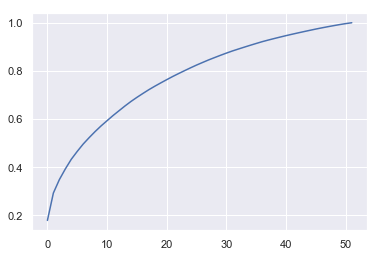

In [373]:
dabsvc = SVD(dabmat_norm)
plt.plot(dabsvc.s.cumsum()/dabsvc.s.sum())

In [82]:
def norm(vec):
    return (vec-vec.mean())/vec.std()

In [344]:
aaa = df6_mean[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
aaa['log FTE'] =norm(df6_mean['log FTE'])
xx6 = aaa.merge(dabmat_norm,left_on='SOCP_shave',right_index=True)

In [345]:
xx6


,SOCP_shave,Occupation,FTE wage,log FTE,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
SOCP,,,,,,,,,,,,,,,,,,,,,
111021,11102,MGR-General And Operations Managers,90534.972952,1.041719,-0.497904,-0.435710,-0.320072,-0.586617,0.549029,-0.014649,...,-0.083004,0.286970,0.137284,0.905369,-0.014401,-0.539315,-0.206892,-0.538011,0.759327,1.031612
112011,11201,MGR-Advertising And Promotions Managers,85658.029752,0.905695,-1.324844,-1.510375,1.318842,-1.638589,1.370241,-0.719007,...,-1.126041,-1.353555,-1.375186,-0.498408,-1.067291,0.667146,0.750555,-0.234854,0.759327,0.947647
112020,11202,MGR-Marketing And Sales Managers,102306.744030,1.393800,-1.536173,-0.834077,0.816594,-1.438001,1.255653,-0.843974,...,-0.925039,-1.353555,-1.375186,0.039209,-0.835202,-0.198359,-0.035919,-0.452336,0.807021,0.989629
112031,11203,MGR-Public Relations And Fundraising Managers,89689.713886,1.202369,-2.087466,-1.250973,0.499385,-1.968445,1.026478,-0.809892,...,-1.126041,-1.353555,-1.375186,0.696296,-0.829542,-0.539315,0.117956,-0.485288,0.854715,1.535400
113011,11301,MGR-Administrative Services Managers,73133.514150,0.662956,-0.194693,-0.083664,-0.002863,-0.301336,0.549029,-0.173698,...,-1.126041,-0.566482,-0.348000,1.263780,-0.738970,-0.749135,0.117956,-0.841168,0.759327,0.947647
113021,11302,MGR-Computer And Information Systems Managers,115292.724615,1.925940,-0.139563,-0.787755,0.155742,-0.185441,1.026478,-0.628122,...,-1.126041,-1.353555,-1.375186,-0.647746,-0.829542,-0.084707,0.442804,0.437364,1.061389,0.933653
113031,11303,MGR-Financial Managers,106907.123661,1.462377,-1.830196,-1.037893,0.909114,-1.647504,1.503927,-1.650577,...,-1.126041,-1.353555,-1.375186,0.128812,-2.023949,-1.361108,-0.685616,-1.750640,0.958052,1.031612
113051,11305,MGR-Industrial Production Managers,82162.689726,0.919490,0.215715,0.873652,0.609527,0.221679,0.908707,0.356464,...,-0.389034,-0.147658,-0.395181,0.756031,-0.001193,0.935248,0.420008,0.325328,0.836168,0.688755
113061,11306,MGR-Purchasing Managers,81468.226981,1.032685,-2.087466,-0.324538,0.975199,-1.968445,0.778205,-0.719007,...,-1.126041,-1.353555,-1.375186,0.128812,-1.214469,-0.644225,-0.514643,-1.262952,0.759327,0.933653


In [346]:
xx6.columns

Index(['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE',
       'Arm-Hand Steadiness', 'Auditory Attention', 'Category Flexibility',
       'Control Precision', 'Deductive Reasoning', 'Depth Perception',
       'Dynamic Flexibility', 'Dynamic Strength', 'Explosive Strength',
       'Extent Flexibility', 'Far Vision', 'Finger Dexterity',
       'Flexibility of Closure', 'Fluency of Ideas', 'Glare Sensitivity',
       'Gross Body Coordination', 'Gross Body Equilibrium',
       'Hearing Sensitivity', 'Inductive Reasoning', 'Information Ordering',
       'Manual Dexterity', 'Mathematical Reasoning', 'Memorization',
       'Multilimb Coordination', 'Near Vision', 'Night Vision',
       'Number Facility', 'Oral Comprehension', 'Oral Expression',
       'Originality', 'Perceptual Speed', 'Peripheral Vision',
       'Problem Sensitivity', 'Rate Control', 'Reaction Time',
       'Response Orientation', 'Selective Attention', 'Sound Localization',
       'Spatial Orientation', 'Speech Clarity',

### LINEAR REGRESSION

In [ ]:
y = xx6['log FTE']
X = xx6.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### RIDGE

In [351]:
reg_ridge = linear_model.Ridge(alpha=.5)
cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)

In [352]:
cv_results_ridge

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.0026691 , 0.002496  , 0.00211096]),
 'score_time': array([0.00213504, 0.00188017, 0.00106287]),
 'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001)),
 'test_score': array([0.51788397, 0.59671867, 0.5860454 ]),
 'train_score': array([0.76109878, 0.75792544, 0.76715935])}

In [456]:
ridge_estimator = cv_results_ridge['estimator'][1]
pd.DataFrame(ridge_estimator.coef_,index = X.columns).sort_values(0,ascending=False)[:5]

,0
Inductive Reasoning,0.556655
Gross Body Equilibrium,0.377854
Deductive Reasoning,0.253144
Rate Control,0.220619
Control Precision,0.187275


#### LASSO

In [353]:
reg_lasso = linear_model.Lasso(alpha=.5)
cv_results_lasso = cross_validate(reg_lasso, X_train, y_train, cv=3, return_estimator=True)

In [354]:
cv_results_lasso

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.00978303, 0.00456882, 0.00244665]),
 'score_time': array([0.00239992, 0.00129914, 0.00123215]),
 'estimator': (Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)),
 'test_score': array([0.38141267, 0.37447784, 0.36660018]),
 'train_score': array([0.39572192, 0.38681761, 0.34964265])}

#### RANDOM FOREST

In [403]:
rf = RandomForestRegressor(n_estimators=10,
                           max_features='auto',
                           random_state=0)
cv_results_rf = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)
cv_results_rf

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.05198812, 0.03204894, 0.03143501]),
 'score_time': array([0.01223969, 0.00151491, 0.00171804]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [396]:
rf_estimator = cv_results_rf['estimator'][1]
rf_estimator.score(X_test,y_test)

0.6804432775318935

In [451]:
pd.DataFrame(rf_estimator.feature_importances_,index = X.columns).sort_values(0,ascending=False)[:5]

,0
Written Comprehension,0.235949
Deductive Reasoning,0.203649
Inductive Reasoning,0.190428
Written Expression,0.065436
Problem Sensitivity,0.021592


In [101]:
from sklearn.ensemble import GradientBoostingRegressor

In [429]:
boo = GradientBoostingRegressor(n_estimators=100, learning_rate=0.08, max_depth=1)
cv_results_boo = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.05881023, 0.05239987, 0.04528904]),
 'score_time': array([0.00275779, 0.00227928, 0.0014081 ]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

#### WITH QUADRATIC TERM   - NO BIG DIFFERENCE

In [438]:
X2 = X.apply(lambda x: x**2).apply(norm)
XX = X.merge(X2, left_index = True, right_index = True)

In [439]:
XX_train, XX_test, y_train, y_test = train_test_split(XX, y, test_size=0.33, random_state=42)

In [441]:
reg_ridge = linear_model.Ridge(alpha=.5)
cv_results_ridge_2 = cross_validate(reg_ridge, XX_train, y_train, cv=3, return_estimator=True)
cv_results_ridge

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.0026691 , 0.002496  , 0.00211096]),
 'score_time': array([0.00213504, 0.00188017, 0.00106287]),
 'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001)),
 'test_score': array([0.51788397, 0.59671867, 0.5860454 ]),
 'train_score': array([0.76109878, 0.75792544, 0.76715935])}

In [446]:
rf = RandomForestRegressor(n_estimators=15,
                           max_features='auto',
                           random_state=0)
cv_results_rf_2 = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)
cv_results_rf_2

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.07451701, 0.043571  , 0.05358005]),
 'score_time': array([0.00181794, 0.00218606, 0.00273108]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [457]:
rf_estimator_2 = cv_results_rf['estimator'][1]
pd.DataFrame(rf_estimator_2.feature_importances_,index = X.columns).sort_values(0,ascending=False)[:5]

,0
Written Comprehension,0.235949
Deductive Reasoning,0.203649
Inductive Reasoning,0.190428
Written Expression,0.065436
Problem Sensitivity,0.021592


#### WITH MIXING ON WRITTEN COMPREHENSION (LARGEST COEF)

In [459]:
X2 = X.drop('Written Comprehension').apply(lambda x, x*X['Written Comprehension'])
XWC = X.merge(X2, left_index = True, right_index = True)

SyntaxError: invalid syntax (<ipython-input-459-dbd9cb2504e6>, line 1)

### NOW DO THE SAME WITH CONTEXT MATRIX  – RESULT: CONTEXT DOES NOT CORRELATE

In [35]:

aaa = dcnm.drop(columns='SOCP shave')
dconmat_norm = (aaa - aaa.mean())/aaa.std()
dconmat_norm

,Consequence of Error,Contact With Others,Coordinate or Lead Others,"Cramped Work Space, Awkward Positions",Deal With External Customers,Deal With Physically Aggressive People,Deal With Unpleasant or Angry People,Degree of Automation,Electronic Mail,Exposed to Contaminants,...,Spend Time Standing,"Spend Time Using Your Hands to Handle, Control, or Feel Objects, Tools, or Controls",Spend Time Walking and Running,Structured versus Unstructured Work,Telephone,Time Pressure,Very Hot or Cold Temperatures,"Wear Common Protective or Safety Equipment such as Safety Shoes, Glasses, Gloves, Hearing Protection, Hard Hats, or Life Jackets","Wear Specialized Protective or Safety Equipment such as Breathing Apparatus, Safety Harness, Full Protection Suits, or Radiation Protection",Work With Work Group or Team
SOCP shave,,,,,,,,,,,,,,,,,,,,,
11101,-0.217341,0.372324,1.776577,-0.586782,0.071508,-0.137721,-0.086482,-0.535142,1.165035,-0.911203,...,-0.807890,-1.211588,-0.651688,1.851990,1.213529,-0.556935,-0.580281,-0.882408,-0.281439,0.749790
11102,-0.420625,0.983347,1.877829,-0.362967,0.664928,-0.316163,0.201791,-0.535142,0.976079,-0.031717,...,-0.372946,-0.818875,-0.300569,2.302695,1.290978,0.527678,-0.614769,-0.148847,-0.546695,1.740151
11201,-1.214082,0.535130,0.535985,-0.248948,0.906787,-0.412819,-0.899700,-0.535142,1.219857,-1.056964,...,-0.807890,-1.158319,-0.783058,1.386746,0.700379,1.036978,-0.781465,-1.006890,-0.576120,0.591845
11202,-0.986455,0.856218,1.212551,-0.711781,0.911538,-0.412819,-0.743180,-0.535142,1.219857,-0.883566,...,-0.722971,-1.051003,-0.783058,0.367678,1.276663,-0.680369,-0.667809,-1.006890,-0.576120,0.628868
11203,-0.608113,1.305944,2.142746,-0.711781,1.120574,-0.412819,-0.558451,-0.535142,1.219857,-0.853656,...,-0.807890,-1.239195,-0.783058,1.211741,1.067072,0.737516,-0.781465,-1.006890,-0.576120,1.548469
11301,-0.626758,-0.269351,0.782974,-0.711781,0.558250,-0.412819,-0.588035,-0.535142,1.109929,-0.493608,...,-0.807890,-1.000067,-0.519634,0.222020,0.697443,-1.346378,-0.644032,-0.851217,-0.576120,0.603191
11302,0.741593,-0.141720,2.445507,-0.699112,-0.814735,-0.412819,-0.750404,-0.500136,1.219857,-1.022512,...,-0.807890,-0.180423,-0.783058,2.402852,-0.480085,-1.538506,-0.781465,-1.006890,-0.576120,1.675660
11303,-0.478633,0.004001,0.698321,-0.711781,-0.014871,-0.412819,-0.128794,-0.535142,1.172439,-1.056964,...,-0.807890,-0.930467,-0.783058,0.214481,1.364207,-0.513464,-0.781465,-1.006890,-0.576120,-0.071879
11305,1.194775,0.370481,1.065375,-0.573410,-0.289986,-0.412819,-0.499512,-0.299433,1.215727,0.198282,...,-0.807174,-1.212949,-0.641678,0.501310,1.164587,0.055586,0.294130,1.152395,-0.491451,1.536327


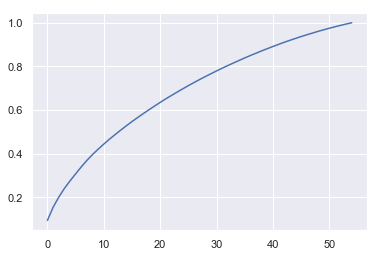

In [38]:
dconsvd = SVD(dconmat_norm)
plt.plot(dconsvd.s.cumsum()/dconsvd.s.sum())

In [84]:
aaa = df6_mean[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
aaa['log FTE'] =norm(df6_mean['log FTE'])
xx6con = aaa.merge(dconmat_norm,left_on='SOCP_shave',right_index=True)

In [89]:
### LINEAR REGRESSION

y = xx6con['log FTE']
X = xx6con.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### RIDGE

reg_ridge = linear_model.Ridge(alpha=.5)
cv_results_ridge_con = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)

cv_results_ridge_con

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.07460308, 0.00210524, 0.00239611]),
 'score_time': array([0.00118208, 0.0011158 , 0.00218296]),
 'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001)),
 'test_score': array([0.49974018, 0.3932383 , 0.28595205]),
 'train_score': array([0.70095548, 0.76113289, 0.76877187])}

In [92]:
ridge_estimator_con = cv_results_ridge_con['estimator'][1]
pd.DataFrame(ridge_estimator_con.coef_,index = X.columns).sort_values(0,ascending=False)[:5]

,0
"Indoors, Environmentally Controlled",0.255136
Freedom to Make Decisions,0.241367
"Sounds, Noise Levels Are Distracting or Uncomfortable",0.238875
Electronic Mail,0.234934
Exposed to Hazardous Equipment,0.219412


In [100]:
#### RANDOM FOREST

rf = RandomForestRegressor(n_estimators=20,
                           max_features='auto',
                           random_state=0)
cv_results_rf_con = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)
cv_results_rf_con

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.08069396, 0.06254411, 0.061234  ]),
 'score_time': array([0.00334811, 0.00201893, 0.00215793]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [106]:
rf_estimator_con = cv_results_rf_con['estimator'][1]
rf_estimator_con.score(X_test,y_test)

pd.DataFrame(rf_estimator_con.feature_importances_,index = X.columns).sort_values(0,ascending=False)[:5]

,0
Spend Time Standing,0.309152
Electronic Mail,0.114099
Exposed to Contaminants,0.040792
Deal With Unpleasant or Angry People,0.040243
Consequence of Error,0.034203


In [105]:
boo = GradientBoostingRegressor(n_estimators=500, learning_rate=0.08, max_depth=1)
cv_results_boo_con = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo_con

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.1749258 , 0.15416408, 0.1605823 ]),
 'score_time': array([0.00120997, 0.00120902, 0.00156784]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=500, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

### NOW BOTH ABILITIES AND CONTEXT - RESULT: CONTEXT DOES NOT CONTRIBUTE

In [110]:
dabcmat_norm = dabmat_norm.merge(dconmat_norm,left_index=True,right_index=True)

In [112]:
dabcmat_norm.shape

(438, 107)

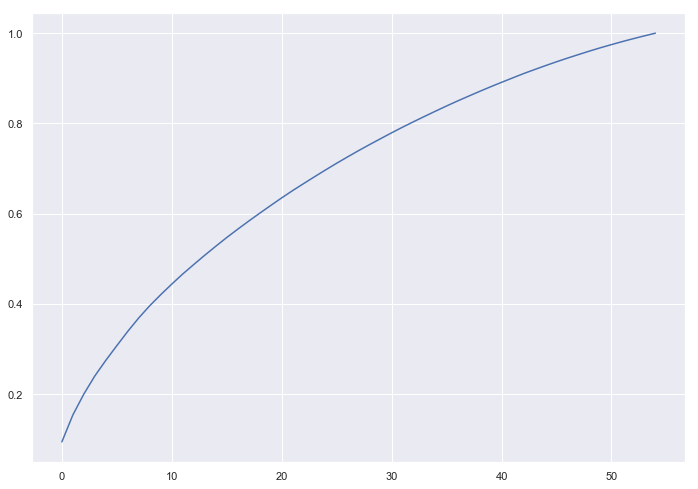

In [113]:
dabcsvd = SVD(dconmat_norm)
plt.plot(dabcsvd.s.cumsum()/dabcsvd.s.sum())

In [114]:
aaa = df6_mean[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
aaa['log FTE'] =norm(df6_mean['log FTE'])
xx6abc = aaa.merge(dabcmat_norm,left_on='SOCP_shave',right_index=True)

In [115]:
### LINEAR REGRESSION

y = xx6abc['log FTE']
X = xx6abc.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### RIDGE

reg_ridge = linear_model.Ridge(alpha=.5)
cv_results_ridge_abc = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)

cv_results_ridge_abc

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.00289416, 0.00288296, 0.00277495]),
 'score_time': array([0.00121284, 0.00135207, 0.001261  ]),
 'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001)),
 'test_score': array([0.51872021, 0.4840726 , 0.46340559]),
 'train_score': array([0.8825958 , 0.90150743, 0.90112452])}

In [116]:
boo = GradientBoostingRegressor(n_estimators=500, learning_rate=0.08, max_depth=1)
cv_results_boo_abc = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo_abc

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.25106311, 0.23524094, 0.23881197]),
 'score_time': array([0.0012579 , 0.00116086, 0.00126314]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=500, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

### PIPELINE FOR TESTING WITH MORE VARIABLE SETS

In [132]:
din = from_onet('Interests')
dkn = from_onet('Knowledge')
dsk = from_onet('Skills')

In [146]:
dete = from_onet('Education, Training, and Experience')

In [149]:
dtsk = from_onet('Task Ratings')

In [135]:
din1 = din[['O*NET-SOC Code','Element Name','Data Value']]

In [140]:
dsk1 = dsk[dsk['Scale Name'] == 'Level']
dsk1 = dsk[['O*NET-SOC Code','Element Name','Data Value']]

,O*NET-SOC Code,Element Name,Data Value
0,11-1011.00,Reading Comprehension,4.12
1,11-1011.00,Reading Comprehension,4.75
2,11-1011.00,Active Listening,4.12
3,11-1011.00,Active Listening,4.88
4,11-1011.00,Writing,4.00


In [162]:
dtsk1 = dtsk[dtsk['Category'] == 7.0]
dtsk1 = dtsk1[['O*NET-SOC Code','Task','Data Value']].dropna()
dtsk1['Element Name'] = dtsk1['Task']

In [142]:
dkn1 = dkn[dkn['Scale Name'] == 'Level']
dkn1 = dkn[['O*NET-SOC Code','Element Name','Data Value']]

In [148]:
ls db_23_2_excel

Abilities.xlsx
Alternate Titles.xlsx
Career Changers Matrix.xlsx
Career Starters Matrix.xlsx
Content Model Reference.xlsx
DWA Reference.xlsx
Education, Training, and Experience Categories.xlsx
Education, Training, and Experience.xlsx
Emerging Tasks.xlsx
Green DWA Reference.xlsx
Green Occupations.xlsx
Green Task Statements.xlsx
IWA Reference.xlsx
Interests.xlsx
Job Zone Reference.xlsx
Job Zones.xlsx
Knowledge.xlsx
Level Scale Anchors.xlsx
Occupation Data.xlsx
Occupation Level Metadata.xlsx
Read Me.txt
Sample of Reported Titles.xlsx
Scales Reference.xlsx
Skills.xlsx
Survey Booklet Locations.xlsx
Task Categories.xlsx
Task Ratings.xlsx
Task Statements.xlsx
Tasks to DWAs.xlsx
Tasks to Green DWAs.xlsx
Technology Skills.xlsx
Tools Used.xlsx
Tools and Technology.xlsx
UNSPSC Reference.xlsx
Work Activities.xlsx
Work Context Categories.xlsx
Work Context.xlsx
Work Styles.xlsx
Work Values.xlsx
graph_analysis.nb


In [122]:

def varset_Xy(dwc1,df6_mean):
    aaa = pd.get_dummies(dwc1['Element Name']) 
    dconmat = dwc1[['O*NET-SOC Code']].join(aaa.multiply(dwc1['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    dconmat['SOCP'] = dconmat.index
    dconmat['SOCP shave']=dconmat['SOCP'].apply(soc)

    # PREPARE CONTEXT MATRIX FOR ADDING TO CENSUS DATA

    dcnm= dconmat.groupby('SOCP shave').mean()
    dcnm['SOCP shave'] = dcnm.index
    
    aaa = dcnm.drop(columns='SOCP shave')
    dconmat_norm = (aaa - aaa.mean())/aaa.std()
    dconmat_norm
    
    dconsvd = SVD(dconmat_norm)
    
    aaa = df6_mean[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    aaa['log FTE'] =norm(df6_mean['log FTE'])
    xx6con = aaa.merge(dconmat_norm,left_on='SOCP_shave',right_index=True)
    
    y = xx6con['log FTE']
    X = xx6con.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)

In [131]:
Xy ={}
Xy['din']=varset_Xy(din1,df6_mean)

In [141]:
Xy['dsk']=varset_Xy(dsk1,df6_mean)

In [143]:
Xy['dkn']=varset_Xy(dkn1,df6_mean)

In [163]:
Xy['tsk']=varset_Xy(dtsk1,df6_mean)

ValueError: array must not contain infs or NaNs

In [168]:
X,y = Xy['din']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
boo = GradientBoostingRegressor(n_estimators=600, learning_rate=0.08, max_depth=1)
cv_results_boo_din = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo_din

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.20134497, 0.27736497, 0.19736791]),
 'score_time': array([0.00363302, 0.00129318, 0.00128818]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=600, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

In [169]:
X,y = Xy['dsk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
boo = GradientBoostingRegressor(n_estimators=600, learning_rate=0.08, max_depth=1)
cv_results_boo_dsk = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo_dsk

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.15327406, 0.14260006, 0.13946223]),
 'score_time': array([0.00118303, 0.00129008, 0.00131488]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=600, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

In [189]:
#### RANDOM FOREST

len(Xy['dsk'][0].columns)

35

In [187]:
X,y = Xy['dsk']
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)
cv_results_rf_dsk = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)
cv_results_rf_dsk

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.11247396, 0.09095573, 0.08164477]),
 'score_time': array([0.00457501, 0.00283623, 0.00273013]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [180]:
cv_results_rf_dsk

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.10439801, 0.08539891, 0.08650494]),
 'score_time': array([0.00363493, 0.00294113, 0.00323915]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [190]:
cv_results_rf_dsk

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.11247396, 0.09095573, 0.08164477]),
 'score_time': array([0.00457501, 0.00283623, 0.00273013]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [185]:
rf_estimator_dsk = cv_results_rf_dsk['estimator'][1]

In [186]:
len(rf_estimator_dsk.feature_importances_)

33

In [184]:
len(X.columns)

35

In [179]:
pd.DataFrame(rf_estimator_dsk.feature_importances_,index = X.columns).sort_values(0,ascending=False)[:5]

ValueError: Shape of passed values is (1, 33), indices imply (1, 35)

In [175]:
X,y = Xy['dkn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
boo = GradientBoostingRegressor(n_estimators=600, learning_rate=0.08, max_depth=1)
cv_results_boo_dkn = cross_validate(boo, X_train, y_train, cv=3, return_estimator=True)
cv_results_boo_dkn

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.18908405, 0.18006611, 0.17505312]),
 'score_time': array([0.00200009, 0.0016458 , 0.00130296]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=600, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.08, loss='ls', max_depth=1, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight

# GENERALIZED LINEAR REGRESSION

## RIDGE

### ALL AGES

In [209]:

# FIT MODEL
from sklearn.model_selection import train_test_split


y = xxx['log FTE']
X = xxx.drop(columns = ['log FTE','SOCP shave_y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Standardize X
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()


In [210]:
# GENERALIZED REGRESSION: 
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix


reg_ridge = linear_model.Ridge(alpha=.5)
#reg_lasso = linear_model.Lasso(alpha=.5)
cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_lasso = cross_validate(reg_lasso, X_train, y_train, cv=3, return_estimator=True)

In [214]:
cv_results_ridge['estimator'][2].score(X_test,y_test)

0.3287803284129843

In [154]:
pd.DataFrame(cv_results_ridge)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,estimator,test_score,train_score
0,4.054119,0.291798,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.329808,0.333456
1,2.818198,0.081113,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.334633,0.330962
2,2.895657,0.067623,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.326429,0.335067


In [49]:
pd.DataFrame(cv_results_lasso)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,estimator,test_score,train_score
0,2.317297,0.066816,"Lasso(alpha=0.5, copy_X=True, fit_intercept=Tr...",-0.000026,0.0
1,2.086845,0.064423,"Lasso(alpha=0.5, copy_X=True, fit_intercept=Tr...",-0.000002,0.0
2,1.954407,0.061409,"Lasso(alpha=0.5, copy_X=True, fit_intercept=Tr...",-0.000015,0.0


### PREDICT log FTE WAGES FROM FIT: 
#### RIDGE IS BETTER THAN LASSO

In [114]:

xmodel_ridge = cv_results_ridge['estimator'][0]
#xmodel_lasso = cv_results_lasso['estimator'][0]
yhat_ridge = xmodel_ridge.predict(X_test)
#yhat_lasso = xmodel_lasso.predict(X_test)
residuals_ridge = yhat_ridge - y_test
#residuals_lasso = yhat_lasso - y_test
msre_ridge = np.sqrt((residuals_ridge**2).mean())
#msre_lasso = np.sqrt((residuals_lasso**2).mean())

# Convert from logFTE to FTE - check Range of error in mean salary - in yearly FTE in dollars
# RIDGE
np.exp(y_test.mean()-msre_ridge), \
np.exp(y_test.mean() ), \
np.exp(y_test.mean()+msre_ridge), 


(30297.449521030194, 48183.57098771826, 76628.77733378076)

In [51]:
# Convert from logFTE to FTE - check Range of error in mean salary - in yearly FTE in dollars
# LASSO
# np.exp(y_test.mean()-msre_lasso), \
# np.exp(y_test.mean() ), \
# np.exp(y_test.mean()+msre_lasso), 

#(27343.579770546137, 48183.57098771826, 84906.82392761606)

(27343.579770546137, 48183.57098771826, 84906.82392761606)

In [69]:
aaa = pd.DataFrame(xmodel_ridge.coef_, index = X_train.columns)
aaa['Feature'] = aaa.index
aaa['index'] = aaa.index
aaa['Code'] = aaa['Feature'].apply(lambda x: x[-5:])
aaa['Feature'] = aaa['Feature'].apply(look_dic)
dfeature_coeffs = aaa.sort_values(0,ascending = False)

dfeature_coeffs[['Code','Feature',0]]

,Code,Feature,0
AGEP,AGEP,{Age},0.103104
SOCP shave_x_29106,29106,{MED-Physicians And Surgeons},0.099960
SOCP shave_x_15113,15113,"{CMM-Web Developers, CMM-Computer Programmers,...",0.075474
SOCP shave_x_11302,11302,{MGR-Computer And Information Systems Managers},0.048868
SOCP shave_x_11303,11303,{MGR-Financial Managers},0.045646
SOCP shave_x_29114,29114,{MED-Registered Nurses},0.044686
SOCP shave_x_13205,13205,"{FIN-Personal Financial Advisors, FIN-Insuranc...",0.043611
SOCP shave_x_11202,11202,{MGR-Marketing And Sales Managers},0.042160
SOCP shave_x_29105,29105,{MED-Pharmacists},0.041756
SOCP shave_x_29102,29102,{MED-Dentists},0.041640


In [249]:
select_abis(dfeature_coeffs)

,0
Written Comprehension,0.016735
Control Precision,0.013788
Explosive Strength,0.012076
Far Vision,0.009159
Speed of Limb Movement,0.009151
Number Facility,0.007656
Peripheral Vision,0.007385
Glare Sensitivity,0.007300
Wrist-Finger Speed,0.006870
Fluency of Ideas,0.006577


#### CHECK HOW AGE PLAYS IN TO THE FIT

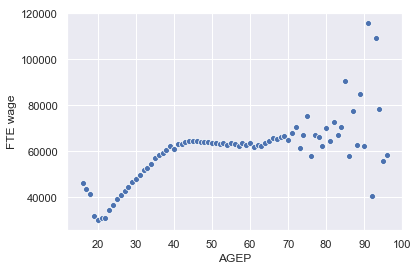

In [100]:
aaa =baz[['AGEP','FTE wage']].groupby('AGEP').mean()
aaa['AGEP'] = aaa.index
sns.scatterplot(x='AGEP',y='FTE wage',data=aaa)

In [115]:
xxx = BM(xx).select(
    'AGEP','gt',40).select(
    'AGEP','lt',63).df

In [108]:
# FIT MODEL
from sklearn.model_selection import train_test_split
y = xxx['log FTE']
X = xxx.drop(columns = ['log FTE','SOCP shave_y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Standardize X
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

reg_ridge = linear_model.Ridge(alpha=.5)
cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)

In [116]:
pd.DataFrame(cv_results_ridge)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,estimator,test_score,train_score
0,3.691149,0.330003,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.329808,0.333456
1,2.541603,0.072416,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.334633,0.330962
2,2.108727,0.068674,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.326429,0.335067


In [118]:
xmodel_ridge = cv_results_ridge['estimator'][0]
#xmodel_lasso = cv_results_lasso['estimator'][0]
yhat_ridge = xmodel_ridge.predict(X_test)
#yhat_lasso = xmodel_lasso.predict(X_test)
residuals_ridge = yhat_ridge - y_test
#residuals_lasso = yhat_lasso - y_test
msre_ridge = np.sqrt((residuals_ridge**2).mean())
#msre_lasso = np.sqrt((residuals_lasso**2).mean())

msre_ridge

0.4639545773274274

In [117]:
# Convert from logFTE to FTE - check Range of error in mean salary - in yearly FTE in dollars
# RIDGE
np.exp(y_test.mean()-msre_ridge), \
np.exp(y_test.mean() ), \
np.exp(y_test.mean()+msre_ridge), 

(30297.449521030194, 48183.57098771826, 76628.77733378076)

In [ ]:
aaa = pd.DataFrame(xmodel_ridge.coef_, index = X_train.columns)
aaa['Feature'] = aaa.index
aaa['index'] = aaa.index
aaa['Code'] = aaa['Feature'].apply(lambda x: x[-5:])
aaa['Feature'] = aaa['Feature'].apply(look_dic)
dfeature_coeffs = aaa.sort_values(0,ascending = False)

dfeature_coeffs[['Code','Feature',0]]

## RANDOM FOREST

In [119]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

In [181]:
rfscr = {}
rfdic = {}

In [204]:
xxx = xx[:90000].T[:108].T
#xxx = xx[:10000]
y = xxx['log FTE'].values
X = xxx.drop(columns = ['log FTE','SOCP shave_y']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)





rfdic = {}

rf = RandomForestRegressor(n_estimators=50,
                           max_features='auto',
                           random_state=0)
#rf.fit(X_train, y_train)

cv_results = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)
rfdic[X_train.shape]=cv_results

In [208]:

cv_results_rf['estimator'][2].score(X_test,y_test)

0.13473600026288646

#### FIT WITH ABILITIES VS OCCUPATIONS - COMPARE WHICH ONE IS BEST

In [61]:
col_abi = ['Arm-Hand Steadiness',
       'Auditory Attention', 'Category Flexibility', 'Control Precision',
       'Deductive Reasoning', 'Depth Perception', 'Dynamic Flexibility',
       'Dynamic Strength', 'Explosive Strength', 'Extent Flexibility',
       'Far Vision', 'Finger Dexterity', 'Flexibility of Closure',
       'Fluency of Ideas', 'Glare Sensitivity', 'Gross Body Coordination',
       'Gross Body Equilibrium', 'Hearing Sensitivity', 'Inductive Reasoning',
       'Information Ordering', 'Manual Dexterity', 'Mathematical Reasoning',
       'Memorization', 'Multilimb Coordination', 'Near Vision', 'Night Vision',
       'Number Facility', 'Oral Comprehension', 'Oral Expression',
       'Originality', 'Perceptual Speed', 'Peripheral Vision',
       'Problem Sensitivity', 'Rate Control', 'Reaction Time',
       'Response Orientation', 'Selective Attention',
       'Sound Localization', 'Spatial Orientation', 'Speech Clarity',
       'Speech Recognition', 'Speed of Closure', 'Speed of Limb Movement',
       'Stamina', 'Static Strength', 'Time Sharing', 'Trunk Strength',
       'Visual Color Discrimination', 'Visualization', 'Wrist-Finger Speed',
       'Written Comprehension', 'Written Expression']

#### OCCUPATIONS 

In [70]:
# FIT MODEL
from sklearn.model_selection import train_test_split
y = xx['log FTE']
X = xx.drop(columns = ['log FTE','SOCP shave_y']+col_abi)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Standardize X
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [72]:
reg_ridge = linear_model.Ridge(alpha=.5)
#reg_lasso = linear_model.Lasso(alpha=.5)
cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_lasso = cross_validate(reg_lasso, X_train, y_train, cv=3, return_estimator=True)
pd.DataFrame(cv_results_ridge)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,estimator,test_score,train_score
0,3.354978,0.097014,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.329813,0.333265
1,1.796799,0.064901,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.334834,0.330702
2,1.806741,0.062900,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.326562,0.334848


In [73]:

xmodel_ridge = cv_results_ridge['estimator'][0]
#xmodel_lasso = cv_results_lasso['estimator'][0]
yhat_ridge = xmodel_ridge.predict(X_test)
#yhat_lasso = xmodel_lasso.predict(X_test)
residuals_ridge = yhat_ridge - y_test
#residuals_lasso = yhat_lasso - y_test
msre_ridge = np.sqrt((residuals_ridge**2).mean())
#msre_lasso = np.sqrt((residuals_lasso**2).mean())

# Convert from logFTE to FTE - check Range of error in mean salary - in yearly FTE in dollars
# RIDGE
np.exp(y_test.mean()-msre_ridge), \
np.exp(y_test.mean() ), \
np.exp(y_test.mean()+msre_ridge), 

(30297.962007587575, 48183.57098771826, 76627.48116678833)

#### ABILITIES

In [79]:
aaa = xx.columns
col_occ = list(aaa[['SOCP shave_x_' in tit for tit in aaa]])
col_occ

['SOCP shave_x_11102',
 'SOCP shave_x_11201',
 'SOCP shave_x_11202',
 'SOCP shave_x_11203',
 'SOCP shave_x_11301',
 'SOCP shave_x_11302',
 'SOCP shave_x_11303',
 'SOCP shave_x_11305',
 'SOCP shave_x_11306',
 'SOCP shave_x_11307',
 'SOCP shave_x_11311',
 'SOCP shave_x_11312',
 'SOCP shave_x_11313',
 'SOCP shave_x_11901',
 'SOCP shave_x_11902',
 'SOCP shave_x_11903',
 'SOCP shave_x_11904',
 'SOCP shave_x_11905',
 'SOCP shave_x_11907',
 'SOCP shave_x_11908',
 'SOCP shave_x_11911',
 'SOCP shave_x_11912',
 'SOCP shave_x_11914',
 'SOCP shave_x_11915',
 'SOCP shave_x_11916',
 'SOCP shave_x_13101',
 'SOCP shave_x_13102',
 'SOCP shave_x_13103',
 'SOCP shave_x_13104',
 'SOCP shave_x_13105',
 'SOCP shave_x_13107',
 'SOCP shave_x_13108',
 'SOCP shave_x_13111',
 'SOCP shave_x_13112',
 'SOCP shave_x_13113',
 'SOCP shave_x_13114',
 'SOCP shave_x_13115',
 'SOCP shave_x_13116',
 'SOCP shave_x_13119',
 'SOCP shave_x_13201',
 'SOCP shave_x_13202',
 'SOCP shave_x_13203',
 'SOCP shave_x_13204',
 'SOCP shav

In [80]:
# FIT MODEL
from sklearn.model_selection import train_test_split
y = xx['log FTE']
X = xx.drop(columns = ['log FTE','SOCP shave_y']+col_occ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Standardize X
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

reg_ridge = linear_model.Ridge(alpha=.5)
#reg_lasso = linear_model.Lasso(alpha=.5)
cv_results_ridge = cross_validate(reg_ridge, X_train, y_train, cv=3, return_estimator=True)
#cv_results_lasso = cross_validate(reg_lasso, X_train, y_train, cv=3, return_estimator=True)
pd.DataFrame(cv_results_ridge)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,fit_time,score_time,estimator,test_score,train_score
0,0.523515,0.016071,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.188999,0.191342
1,0.402774,0.011116,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.194186,0.188659
2,0.378665,0.011463,"Ridge(alpha=0.5, copy_X=True, fit_intercept=Tr...",0.186900,0.192362


In [81]:
xmodel_ridge = cv_results_ridge['estimator'][0]
#xmodel_lasso = cv_results_lasso['estimator'][0]
yhat_ridge = xmodel_ridge.predict(X_test)
#yhat_lasso = xmodel_lasso.predict(X_test)
residuals_ridge = yhat_ridge - y_test
#residuals_lasso = yhat_lasso - y_test
msre_ridge = np.sqrt((residuals_ridge**2).mean())
#msre_lasso = np.sqrt((residuals_lasso**2).mean())

# Convert from logFTE to FTE - check Range of error in mean salary - in yearly FTE in dollars
# RIDGE
np.exp(y_test.mean()-msre_ridge), \
np.exp(y_test.mean() ), \
np.exp(y_test.mean()+msre_ridge), 

(28928.52080880418, 48183.57098771826, 80254.93347803342)

In [82]:
y.apply(np.exp).mean()

58486.17280428621

In [37]:
from sklearn.decomposition import NMF

# Singular-value decomposition
from numpy import array
from scipy.linalg import svd
# define a matrix
# SVD
#U, s, VT = svd(X)
#plt.plot(s.cumsum()/sum(s))

class nmf:
    def __init__(self,X,n):
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.h = self.model.components_
        self.ph = pd.DataFrame(self.h,columns=X.columns)
        self.ph.n = nrmcol(self.ph.T).T


class SVD:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(X)
        self.pvt = pd.DataFrame(self.vt,columns=X.columns)
        self.pu = pd.DataFrame(self.u,columns=X.index)

        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))

In [85]:
xx['AGEP'].sample(20)

723039     43.0
49996      39.0
960486     56.0
316904     31.0
399831     66.0
6012       53.0
175486     42.0
32890      37.0
8548       35.0
210627     38.0
101662     62.0
95115      56.0
751400     65.0
101339     48.0
1735337    66.0
403615     36.0
32972      55.0
280881     39.0
19108      40.0
18983      48.0
Name: AGEP, dtype: float64

# CLUSTER-CATEGORIZE OCCUPATIONS FROM ABILITIES

In [215]:
dabmat_weight.shape

(967, 54)

In [216]:
X=dabmat_weight.drop(['SOCP','SOCP shave'],axis=1)

In [220]:
abisvd = SVD(X)

In [221]:
abisvd.s

array([552.45140154, 139.99339262,  42.76638641,  42.30710326,
        24.88976664,  22.46930675,  19.55721158,  17.98638066,
        16.62159167,  16.47517164,  14.19136195,  13.73899157,
        12.72140066,  11.89929262,  11.68945289,  11.04287512,
        10.70258307,   9.65639283,   9.36074008,   9.24664518,
         9.18490782,   8.7126173 ,   8.54343477,   8.32173958,
         8.06003459,   7.61668722,   7.43547711,   7.22114209,
         6.98037153,   6.90762906,   6.69146477,   6.46570751,
         6.23231232,   6.10276614,   6.03838792,   5.74615161,
         5.59876198,   5.44988165,   5.28629732,   5.16096902,
         5.01405987,   4.77663508,   4.58067408,   4.23008716,
         4.10675442,   3.99113519,   3.91616187,   3.79058874,
         3.62084841,   3.16779381,   3.05600501,   2.82285845])

In [225]:
nmf(X,5).ph.n

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,0.339042,0.133924,0.128753,0.338466,0.111941,0.150774,0.000000,0.036496,0.000000,0.062649,...,0.000000,0.000000,0.076672,0.092357,0.072596,0.195223,0.175363,0.199649,0.112381,0.082350
1,0.019591,0.140756,0.034052,0.173730,0.067158,0.197354,0.000000,0.004497,0.015159,0.014019,...,0.128705,0.000000,0.028859,0.099781,0.006233,0.065004,0.073898,0.064797,0.051822,0.053690
2,0.103171,0.078202,0.090578,0.000000,0.088928,0.036434,0.073409,0.282650,0.144041,0.330187,...,0.181745,0.340533,0.317041,0.101662,0.303507,0.049570,0.052034,0.028320,0.078418,0.069002
3,0.029859,0.106166,0.178779,0.019558,0.226075,0.000000,0.000000,0.000000,0.000416,0.000000,...,0.000000,0.005067,0.000000,0.165315,0.072072,0.063476,0.070502,0.000000,0.263475,0.264376
4,0.011775,0.060538,0.198265,0.022813,0.205458,0.161285,0.000000,0.003621,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.072483,0.000000,0.184923,0.265269,0.034878,0.172015,0.152875


In [597]:
nrmcol(nmf(X,10).ph)

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,0.004988,0.034823,0.106859,0.000000,0.055605,0.000000,0.000000,0.155673,0.004467,0.096590,...,0.000000,0.000000,0.000000,0.012378,0.287931,0.053853,0.246930,0.853053,0.070205,0.062611
1,0.007044,0.446187,0.161234,0.003887,0.119891,0.244967,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.255182,0.000000,0.317318,0.409630,0.013802,0.084324,0.088716
2,0.152339,0.163851,0.075803,0.284513,0.100009,0.576893,0.000000,0.000000,0.000000,0.024263,...,0.110701,0.000000,0.168814,0.074133,0.000000,0.213746,0.169366,0.521628,0.063223,0.056737
3,0.000000,0.000000,0.665639,0.027882,0.710415,0.290108,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.289583,0.001286,0.332688,0.478216,0.003852,0.636643,0.648105
4,0.000000,0.171931,0.301591,0.000000,0.340315,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020604,0.000000,0.322464,0.239359,0.072877,0.137261,0.000000,0.374390,0.441565
5,0.044271,0.000000,0.125922,0.046473,0.084712,0.562594,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001447,0.027621,0.000000,0.382504,0.686005,0.000000,0.036905,0.072192
6,0.047138,0.128618,0.037463,0.153735,0.053305,0.410526,0.000000,0.030588,0.000000,0.053907,...,0.333555,0.000000,0.001923,0.129388,0.028741,0.086619,0.111032,0.000000,0.047899,0.048696
7,0.050702,0.190677,0.014454,0.000000,0.071485,0.000000,0.493546,0.337814,0.999990,0.223236,...,0.000000,0.419603,0.536786,0.115742,0.171567,0.078261,0.052460,0.000000,0.005491,0.019929
8,0.976123,0.828600,0.626268,0.944704,0.577587,0.000000,0.000000,0.000000,0.000000,0.084104,...,0.000000,0.000000,0.224017,0.832330,0.159820,0.755072,0.093283,0.000000,0.658768,0.601656
9,0.130954,0.061800,0.114567,0.000000,0.057398,0.194885,0.869720,0.927746,0.000000,0.964504,...,0.936209,0.907474,0.795721,0.133112,0.896659,0.068259,0.025065,0.000000,0.028633,0.000000


In [453]:
sns.set(color_codes=True)

Text(0.5,1,'STANDARD AVERAGE SET OF ABILITIES FOR ALL OCCUPATIONS \nCOVERS 46.0 PERCENT OF ALL PROFILED OCCUPATIONS')

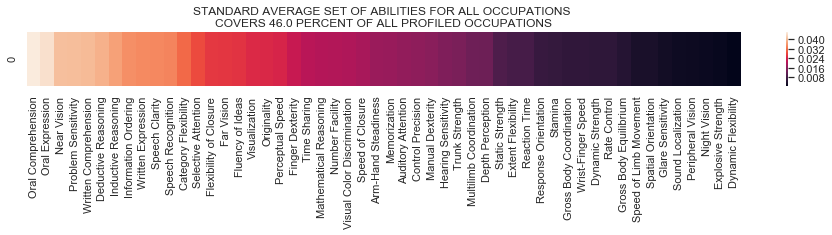

In [720]:
plt.figure(figsize=(16, 1))
sns.heatmap((SVD(X).pvt.T[[0]].apply(lambda x: x**2).sort_values(0,ascending = False)).T)
plt.title('STANDARD AVERAGE SET OF ABILITIES FOR ALL OCCUPATIONS \nCOVERS ' + str( round(100 * SVD(X).s[0]/sum(SVD(X).s))) +' PERCENT OF ALL PROFILED OCCUPATIONS')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Text(0.5,1,'NMF CATEGORIZATION:  N=2')

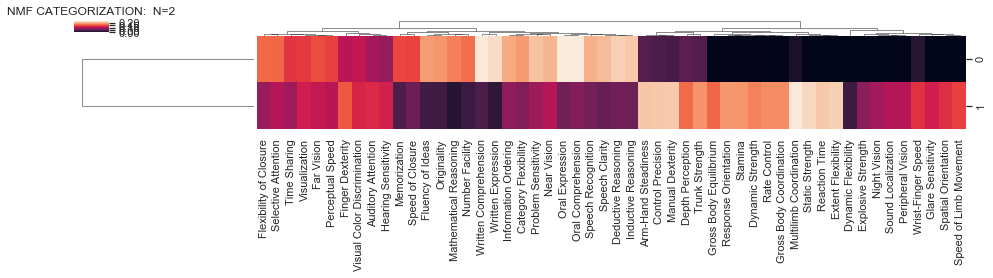

In [722]:
sns.clustermap(nmf(X,2).ph.n.T.sort_values(0,ascending = False).T,figsize=(16, 2))
plt.title('NMF CATEGORIZATION:  N=2')

In [228]:
nmf(X,4).ph.n.T.sort_values(3,ascending = False)[[3]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,3
Oral Expression,0.253927
Oral Comprehension,0.250694
Written Comprehension,0.249832
Written Expression,0.244512
Deductive Reasoning,0.232753
Inductive Reasoning,0.227603
Speech Clarity,0.225232
Problem Sensitivity,0.222712
Speech Recognition,0.214767
Near Vision,0.207312


In [712]:
nrmnmf(X,2).ph

NameError: name 'nrmnmf' is not defined

In [714]:
nmf(X,2).ph.n

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,0.330169,0.721156,0.959506,0.288308,0.975841,0.431049,0.0,0.010471,0.0,0.0,...,0.0,0.002651,0.001695,0.898975,0.364332,0.781143,0.850863,0.250198,0.989645,0.995889
1,0.943922,0.692772,0.281687,0.957538,0.218481,0.902328,1.0,0.999945,1.0,1.0,...,1.0,0.999996,0.999999,0.437999,0.931269,0.624352,0.525387,0.968195,0.143538,0.090577


In [481]:
hh.T.sort_values(8,ascending=False)

,0,1,2,3,4,5,6,7,8,9
Manual Dexterity,0.013339,0.000000,1.009123,0.000000,0.000000,0.197603,0.489655,0.058404,4.645660,0.792457
Arm-Hand Steadiness,0.102631,0.000000,0.997214,0.000000,0.000000,0.390367,0.342542,0.167017,4.495280,0.747601
Finger Dexterity,0.137172,0.406594,0.799185,0.470958,0.335474,0.328543,0.210867,0.293630,3.883104,0.296147
Control Precision,0.000000,0.006822,1.274951,0.128852,0.000000,0.613698,0.639997,0.459561,3.434654,0.000000
Near Vision,0.359739,0.505092,0.581547,2.045356,0.890776,0.206750,0.212167,0.358992,2.963787,0.208185
Selective Attention,0.269683,0.551015,0.541335,1.288676,0.849139,0.030138,0.221242,0.648516,2.190636,0.177420
Speech Recognition,0.416679,0.370182,0.350032,2.014383,1.153367,0.000000,0.142682,0.379440,2.056493,0.336155
Oral Comprehension,0.630666,0.361662,0.396120,2.554262,1.206999,0.073647,0.118745,0.337241,2.016830,0.339384
Perceptual Speed,0.248950,0.784474,0.501506,1.035435,0.524612,0.041512,0.244595,0.758140,1.881778,0.054054
Oral Expression,0.635383,0.303669,0.353908,2.611498,1.272707,0.075863,0.114817,0.328596,1.788167,0.340071


NameError: name 'foo' is not defined